# The spatial distribution of BSS

This notebook computes and visualizes the spatial distribution of Brier Skill Scores (BSS) in the 80-km CONUS domain and with the verification time of 2021-2022.

When computing BSS on each grid cell, forecast-observation pairs from its neighboring grid cells were also considered (e.g., 3-by-3, 5-by-5 grids). The grid cell will be ignored if the number of severe weather reports is below 150.

In [ ]:
# general tools
import os
import re
import sys
import time
import h5py
import random
import netCDF4 as nc
from glob import glob

import numpy as np
from datetime import datetime, timedelta
from random import shuffle

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [ ]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [5]:
colors_sub = np.array([[248, 206, 204], [218, 232, 252], [213, 232, 212]])/255
colors_main = [red, blue, green]

gray_main = np.array([102, 102, 102])/255
gray_sub = np.array([245, 245, 245])/255

In [6]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    elev_3km = h5io['elev_3km'][...]
    state_id = h5io['state_id'][...]
    land_mask_80km = h5io['land_mask_80km'][...]

**Load forecast-observation pairs**

In [7]:
with h5py.File(save_dir+'CNN_ExWeather_HRRRv4_2021.hdf', 'r') as h5io:
    STD_SAVE = h5io['y_std'][...]
    PRED_SAVE = h5io['y_pred'][...]
    TRUE_SAVE = h5io['y_true'][...]
    leads = h5io['lead_times'][...]

**Compute BSS**

In [8]:
pred_cgan = PRED_SAVE[:, :, ..., 0].reshape(365*21, 65, 93)
pred_cnn = PRED_SAVE[:, :, ..., 1].reshape(365*21, 65, 93)
pred_mlp = PRED_SAVE[:, :, ..., 2].reshape(365*21, 65, 93)
LABEL = TRUE_SAVE[:, :, ..., 0].reshape(365*21, 65, 93)

In [9]:
bss_grid_cgan = np.empty((65, 93)); bss_grid_cgan[...] = np.nan
bss_grid_cnn = np.empty((65, 93)); bss_grid_cnn[...] = np.nan
bss_grid_mlp = np.empty((65, 93)); bss_grid_mlp[...] = np.nan
N_obs = np.zeros((65, 93))

grid_shape = lon_80km.shape
rad = 2

for iy in range(grid_shape[0]):
    for ix in range(grid_shape[1]):
        edge_left = np.max([ix-rad, 0])
        edge_right = np.min([ix+rad, grid_shape[1]-1])
        
        edge_top = np.min([iy+rad, grid_shape[0]-1])
        edge_bot = np.max([iy-rad, 0])
        
        pred_cgan_ = pred_cgan[:, edge_bot:edge_top+1, edge_left:edge_right+1]
        pred_cnn_ = pred_cnn[:, edge_bot:edge_top+1, edge_left:edge_right+1]
        pred_mlp_ = pred_mlp[:, edge_bot:edge_top+1, edge_left:edge_right+1]
        
        label_ = LABEL[:, edge_bot:edge_top+1, edge_left:edge_right+1]

    
        bs_cgan = np.nanmean((label_ - pred_cgan_)**2)
        bs_cnn = np.nanmean((label_ - pred_cnn_)**2)
        bs_mlp = np.nanmean((label_ - pred_mlp_)**2)
    
        obar = np.nanmean(label_)
        if obar == 0:
            bss_cgan = np.nan
            bss_cnn = np.nan
            bss_mlp = np.nan
        else:
            bss_cgan = (obar - bs_cgan)/obar
            bss_cnn = (obar - bs_cnn)/obar
            bss_mlp = (obar - bs_mlp)/obar
    
        bss_grid_cgan[iy, ix] = bss_cgan
        bss_grid_cnn[iy, ix] = bss_cnn
        bss_grid_mlp[iy, ix] = bss_mlp
    
        N_obs[iy, ix] = np.nansum(label_)

/glade/scratch/ksha/ipykernel_46874/4069704843.py:24: RuntimeWarning: Mean of empty slice
  bs_cgan = np.nanmean((label_ - pred_cgan_)**2)
/glade/scratch/ksha/ipykernel_46874/4069704843.py:25: RuntimeWarning: Mean of empty slice
  bs_cnn = np.nanmean((label_ - pred_cnn_)**2)
/glade/scratch/ksha/ipykernel_46874/4069704843.py:26: RuntimeWarning: Mean of empty slice
  bs_mlp = np.nanmean((label_ - pred_mlp_)**2)
/glade/scratch/ksha/ipykernel_46874/4069704843.py:28: RuntimeWarning: Mean of empty slice
  obar = np.nanmean(label_)


**Remove N_bos <= 150; apply land mask**

In [10]:
bss_grid_cgan[N_obs<=150] = np.nan
bss_grid_cnn[N_obs<=150] = np.nan
bss_grid_mlp[N_obs<=150] = np.nan
N_obs[~land_mask_80km] = np.nan

In [11]:
bss_grid_cgan[~land_mask_80km] = np.nan
bss_grid_cnn[~land_mask_80km] = np.nan
bss_grid_mlp[~land_mask_80km] = np.nan

**Figure**

In [15]:
cmap_pct, A = gu.precip_cmap()
cmap_diff = plt.cm.RdBu_r
none_map = colors.ListedColormap(['none'])

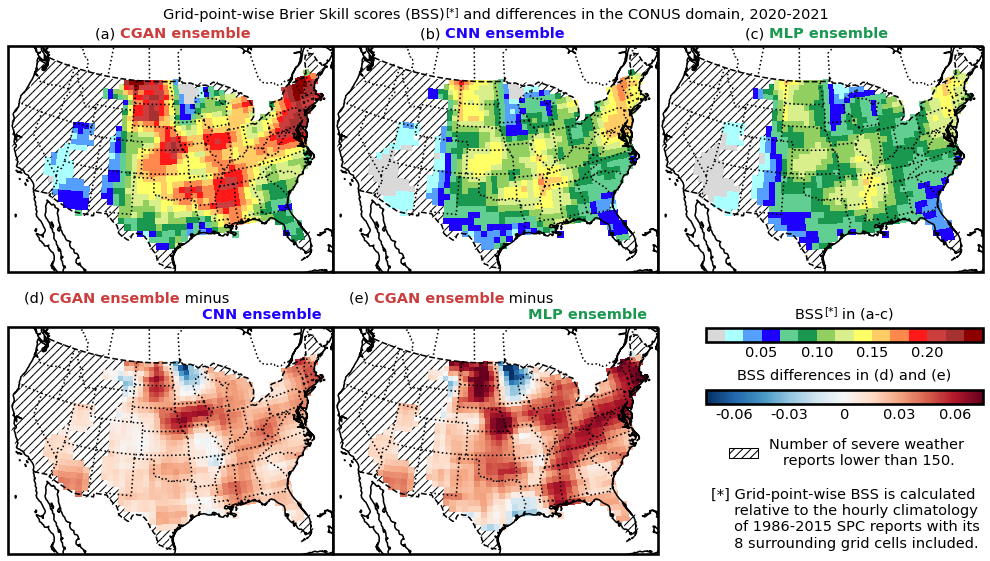

In [19]:
edge = [-118, -77.5, 25.5, 51.5]
# ind = 123 for v4 testing / 29+123 for all v4

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)

fig = plt.figure(figsize=(13, 7.5), dpi=dpi_) #, dpi=dpi_
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

proj_ = ccrs.NorthPolarStereo(central_longitude=-98.75)


ax1 = plt.subplot(gs[0, 0], projection=proj_)
ax2 = plt.subplot(gs[0, 1], projection=proj_)
ax3 = plt.subplot(gs[0, 2], projection=proj_)

ax4 = plt.subplot(gs[1, 0], projection=proj_)
ax5 = plt.subplot(gs[1, 1], projection=proj_)
# ax6 = plt.subplot(gs[1, 2], projection=proj_)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

for i, ax in enumerate([ax1, ax2, ax3, ax4, ax5]):
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5, zorder=5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    
CS1 = ax1.pcolormesh(lon_80km, lat_80km, bss_grid_cgan, vmin=0, vmax=0.25, cmap=cmap_pct, transform=ccrs.PlateCarree())
ax2.pcolormesh(lon_80km, lat_80km, bss_grid_cnn, vmin=0, vmax=0.3, cmap=cmap_pct, transform=ccrs.PlateCarree())
ax3.pcolormesh(lon_80km, lat_80km, bss_grid_mlp, vmin=0, vmax=0.3, cmap=cmap_pct, transform=ccrs.PlateCarree())

CS2 = ax4.pcolormesh(lon_80km, lat_80km, bss_grid_cgan-bss_grid_cnn, vmin=-0.075, vmax=0.075, cmap=cmap_diff, transform=ccrs.PlateCarree())
ax5.pcolormesh(lon_80km, lat_80km, bss_grid_cgan-bss_grid_mlp, vmin=-0.075, vmax=0.075, cmap=cmap_diff, transform=ccrs.PlateCarree())

label_mask = np.ma.array(N_obs, mask=N_obs>=150)
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.pcolor(lon_80km, lat_80km, label_mask, cmap=none_map, edgecolor='k', hatch='///', lw=0.0, zorder=5, transform=ccrs.PlateCarree())


# CS3 = ax6.pcolormesh(lon_80km, lat_80km, N_obs, vmin=0, vmax=500, cmap=plt.cm.gray_r, transform=ccrs.PlateCarree())

fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']
gap_x = 0.225

ax_title1 = fig.add_axes([0.0, 0.96, 1/3, 0.025])
ax_title1.set_axis_off()
colors_ = ['k', colors_main[0], 'k', 'k', 'k']
gu.string_partial_format(fig, ax_title1, 0.27, 1.0, 'left', 'top', 
                         ['(a) ', 'CGAN ensemble'], colors_, fontsize_list, fontweight_list)

ax_title2 = fig.add_axes([1/3, 0.96, 1/3, 0.025])
ax_title2.set_axis_off()
colors_ = ['k', colors_main[1], 'k', 'k', 'k']
gu.string_partial_format(fig, ax_title2, 0.27, 1.0, 'left', 'top', 
                         ['(b) ', 'CNN ensemble'], colors_, fontsize_list, fontweight_list)

ax_title3 = fig.add_axes([2/3, 0.96, 1/3, 0.025])
ax_title3.set_axis_off()
colors_ = ['k', colors_main[2], 'k', 'k', 'k']
gu.string_partial_format(fig, ax_title3, 0.27, 1.0, 'left', 'top', 
                         ['(c) ', 'MLP ensemble'], colors_, fontsize_list, fontweight_list)


ax_title4 = fig.add_axes([0, 0.46+0.03, 1/3, 0.025])
ax_title4.set_axis_off()
colors_ = ['k', colors_main[0], 'k', colors_main[1], 'k']
gu.string_partial_format(fig, ax_title4, 0.05, 1.0, 'left', 'top', 
                         ['(d) ', 'CGAN ensemble', ' minus ',], colors_, fontsize_list, fontweight_list)

ax_title4 = fig.add_axes([0, 0.46, 1/3, 0.025])
ax_title4.set_axis_off()
colors_ = [colors_main[1], 'k']
gu.string_partial_format(fig, ax_title4, 0.6, 1.0, 'left', 'top', 
                         ['CNN ensemble',], colors_, fontsize_list, ['bold',])

ax_title5 = fig.add_axes([1/3, 0.46+0.03, 1/3, 0.025])
ax_title5.set_axis_off()
colors_ = ['k', colors_main[0], 'k', colors_main[1], 'k']
gu.string_partial_format(fig, ax_title5, 0.05, 1.0, 'left', 'top', 
                         ['(e) ', 'CGAN ensemble', ' minus ',], colors_, fontsize_list, fontweight_list)

ax_title5 = fig.add_axes([1/3, 0.46, 1/3, 0.025])
ax_title5.set_axis_off()
colors_ = [colors_main[2], 'k']
gu.string_partial_format(fig, ax_title5, 0.6, 1.0, 'left', 'top', 
                         ['MLP ensemble',], colors_, fontsize_list, ['bold',])

loc_y = 0.46
gap_y = 0.11
gap_text = 0.06

ax_cbar1 = fig.add_axes([2/3+0.05, loc_y, 1/3-0.05, 0.03])
ax_cbar1.set_axis_off()
ax_cbar1.text(0.5, 0.5, 'BSS    in (a-c)', va='center', ha='center', fontsize=14, transform=ax_cbar1.transAxes)

ax_base1 = fig.add_axes([2/3+0.05, loc_y-gap_text, 1/3-0.05, 0.05])
[j.set_linewidth(1.0) for j in ax_base1.spines.values()]
ax_base1.set_axis_off()
ax_base1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base1, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS1, orientation='horizontal', ticks=[0.05, 0.1, 0.15, 0.2], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)

ax_cbar2 = fig.add_axes([2/3+0.05, loc_y-gap_y, 1/3-0.05, 0.03])
ax_cbar2.set_axis_off()
ax_cbar2.text(0.5, 0.5, 'BSS differences in (d) and (e)', va='center', ha='center', fontsize=14, transform=ax_cbar2.transAxes)

ax_base2 = fig.add_axes([2/3+0.05, loc_y-gap_y-gap_text, 1/3-0.05, 0.05])
[j.set_linewidth(1.0) for j in ax_base2.spines.values()]
ax_base2.set_axis_off()
ax_base2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base2, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS2, orientation='horizontal', ticks=[-0.06, -0.03, 0, 0.03, 0.06], cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)
CBar.ax.set_xticklabels(['-0.06', '-0.03', '0', '0.03', '0.06']);

handle_legneds = []
handle_legneds.append(patches.Patch(facecolor='w', edgecolor='k', hatch='///', label=''))

ax_lg = fig.add_axes([2/3+0.045, loc_y-gap_y-gap_y-0.0625, 1/3-0.05, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handle_legneds, ['Number of severe weather\n   reports lower than 150.',], 
                  bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})

LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_all = fig.add_axes([0.5-(0.5*0.68), 1.0, 0.68, 0.02])
ax_all.set_axis_off()
gu.string_partial_format(fig, ax_all, 0.0, 1.0, 'left', 'top', 
                 ['Grid-point-wise Brier Skill scores (BSS)    and differences in the CONUS domain, 2020-2021',],
                 ['k',], [14,], ['normal',]);

ax_all.text(0.425, 1.0, '[*]', va='top', fontsize=10, transform=ax_all.transAxes)
ax_cbar1.text(0.425, 1.0, '[*]', va='top', fontsize=10, transform=ax_cbar1.transAxes)
#ax_cbar2.text(0.188, 1.0, '[*]', va='top', fontsize=10, transform=ax_cbar2.transAxes)

ax_w1 = fig.add_axes([2/3+0.05, 0.05, 1/3-0.05, 0.12])
ax_w1.set_axis_off()
ax_w1.text(0.0175, 0.5, '[*] Grid-point-wise BSS is calculated\n     relative to the hourly climatology\n     of 1986-2015 SPC reports with its\n     8 surrounding grid cells included.', 
          ha='left', va='center', fontsize=14, transform=ax_w1.transAxes);

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig8_spatial_bss.png', format='png', **fig_keys)